In [1]:
# Imports and read the simpson data in
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder
import datetime

In [2]:
simpsons_df = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False, warn_bad_lines=False, low_memory=False, index_col='id')

def dict_from_csv(csv_file_name):
    with open(csv_file_name, mode='r') as infile:
        next(infile)
        reader = csv.reader(infile)
        return_dict = {int(rows[0]):rows[1] for rows in reader}
        return return_dict

character_dict = dict_from_csv('simpsons_characters.csv')
location_dict = dict_from_csv('simpsons_locations.csv') 

In [3]:
# Clear up the data
# We need to have value in character_id, location_id, and normalized_text so we drop nan rows
simpsons_df = simpsons_df.dropna(subset=['character_id', 'location_id', 'normalized_text'])
# In number, timestamp_in_ms, raw_text, and speaking_line we have no extra information so we drop those columns
simpsons_df = simpsons_df.drop(['number', 'timestamp_in_ms', 'raw_text', 'speaking_line'], axis=1)
# Change numeric values to numeric
simpsons_df['character_id'] = pd.to_numeric(simpsons_df['character_id'])
simpsons_df['location_id'] = pd.to_numeric(simpsons_df['location_id'], downcast='integer')
simpsons_df['word_count'] = pd.to_numeric(simpsons_df['word_count'], downcast='integer')

In [4]:
# Count how many lines each character has
character_line_counts = Counter(simpsons_df['character_id']).most_common()

most_common_characters = []

# If character has fewer than 200 lines we will not inlcude that character
for character in character_line_counts:
    if character[1] >= 1500:
        most_common_characters.append(character[0])
simpsons_df = simpsons_df[simpsons_df['character_id'].isin(most_common_characters)]

temp_dict = {character: character_dict[character] for character in most_common_characters}
character_dict = temp_dict

In [5]:
# Count how many lines are at location
locations = Counter(simpsons_df['location_id']).most_common()

most_common_locations = []

# If there are fewer than 100 lines at location we do not use that location
for location in locations:
    if location[1] >= 100:
        most_common_locations.append(location[0])
simpsons_df = simpsons_df[simpsons_df['location_id'].isin(most_common_locations)]

temp_dict = {location: location_dict[location] for location in most_common_locations}
location_dict = temp_dict

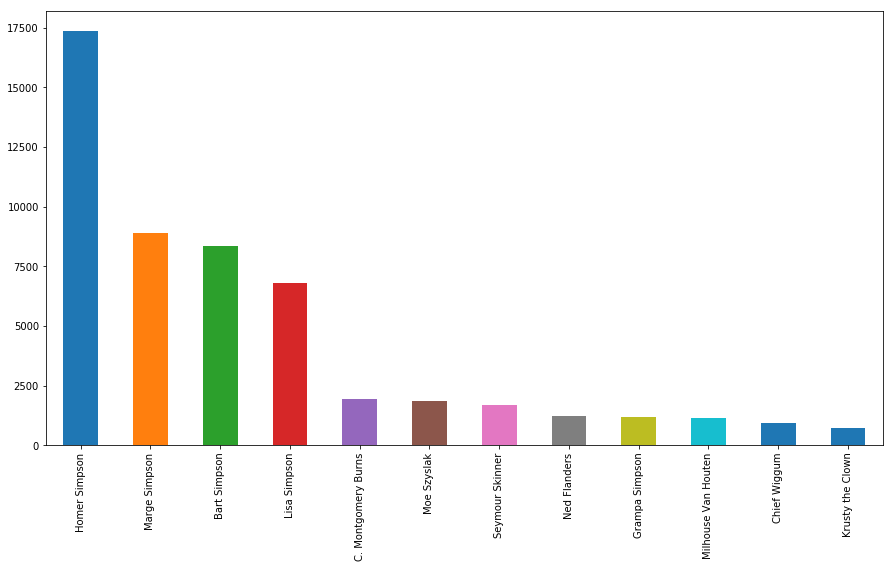

In [6]:
# Here we count how many sentences each character has 
value_counts = simpsons_df['character_id'].value_counts()
# Plot a bar plot with the counts
count_plot = value_counts.plot(kind='bar', figsize=(15,8))
# Change the ID of thoose characters to names
count_plot.set_xticklabels([character_dict[i] for i in value_counts.keys()])
plt.show()

In [7]:
# GOTT FYRIR SKÝRSLU: NOTUM TfidfVectorizer útaf því það er nákvæmara en CountVectorizer
# CountVectorizer telur bara frequncy á orðunum en TfidfVectorizer gerir mun á hversu frequent orð eru
# Nánara info hér: https://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1

# Min_df is the minimum amount of toke frequency to be kept
# stop_words is to skip words like 'a, the' etc.
# sublinear_tf is used so we can do sublinear tf scaling (replace tf with 1+log(tf))
# Norm L2 is L2-normalization to minimize single outliers
# ngram_range is 1,3 so we select tokens of wordsizes: 1, 2 and 3

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english', norm='l2', ngram_range=(1,3))

features = tfidf.fit_transform(simpsons_df.normalized_text)
labels = simpsons_df.character_id
features.shape

(52204, 8895)

In [8]:
most_popular_df = pd.DataFrame()
# Get the 5 most popular tokens
token_count = 5
tokenNames = ['Token ' + str(i) for i in range(1, token_count+1)]

for character_id in character_dict:
    features_chi2 = chi2(features, labels == character_id)
    # Here the we sort the most common features of each character in order
    # features_chi2[0] stands for chi statistics of each character
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # Split features in single or two word grams
    unigrams = [word for word in feature_names if len(word.split(' ')) == 1]
    biggrams = [words for words in feature_names if len(words.split(' ')) == 2]
    
    # If we don't have enough tokens for any charater we fill it with nan 
    if len(unigrams) < token_count:
        for i in range(len(unigrams), token_count+1):
            unigrams.append(np.nan)
    if len(biggrams) < token_count:
        for i in range(len(biggrams), token_count+1):
            biggrams.append(np.nan)
    
    # Append most common single word tokens to the dataframe
    character = "UNI: " + character_dict[character_id]
    most_popular_df = most_popular_df.append(
        pd.DataFrame([unigrams[-token_count:]], index=[character], columns=tokenNames))
    # Append the most common two word tokens to the dataframe
    character = "BIG: " + character_dict[character_id]                                          
    most_popular_df = most_popular_df.append(pd.DataFrame([biggrams[-token_count:]], index=[character], columns=tokenNames))
                                               
most_popular_df.head(10)

,Token 1,Token 2,Token 3,Token 4,Token 5
UNI: Homer Simpson,hoo,dad,woo,homer,marge
BIG: Homer Simpson,marge youre,heh heh,marge im,oh marge,woo hoo
UNI: Marge Simpson,husband,hey,dad,homie,homer
BIG: Marge Simpson,homer doing,homie im,homer dont,oh homer,oh homie
UNI: Bart Simpson,carumba,cool,milhouse,dad,lis
BIG: Bart Simpson,radioactive man,aye carumba,hey dad,hey lis,ay carumba
UNI: Lisa Simpson,marge,homer,bart,mom,dad
BIG: Lisa Simpson,dad think,oh dad,dad did,dad im,dad thats
UNI: C. Montgomery Burns,hounds,bah,simpson,excellent,smithers
BIG: C. Montgomery Burns,youre fired,oh smithers,look smithers,smithers im,simpson eh


In [9]:
x_train, x_test, y_train, y_test = train_test_split(simpsons_df[['normalized_text', 'location_id', 'episode_id', 'word_count']], simpsons_df['character_id'], random_state=42, test_size=0.2)
x_train_vec = tfidf.fit_transform(x_train['normalized_text'])
x_test_vec = tfidf.transform(x_test['normalized_text'])
x_train_others = x_train[['location_id', 'episode_id', 'word_count']]
x_test_other = x_test[['location_id', 'episode_id', 'word_count']]


In [10]:
def print_cnf_matrix(test, prediction):
    cnf_matrix = confusion_matrix(test, prediction)
    plt.subplots(figsize=(15,8))
    sns.heatmap(cnf_matrix, annot=False, fmt='d', vmax=100, cmap='GnBu')
    plt.show()

The accuracy is: 0.3580116847045302


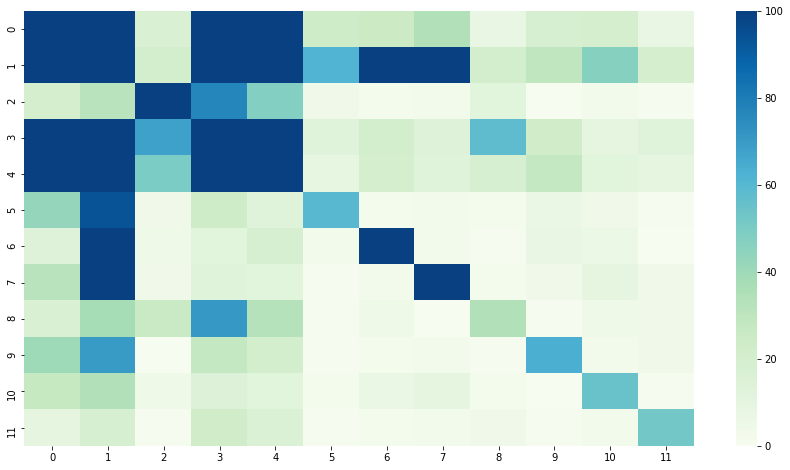

In [11]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train_others, y_train)

prediction = clf.predict(x_test_other)
print("The accuracy is:", accuracy_score(y_test, prediction))
print_cnf_matrix(y_test, prediction)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The accuracy is: 0.4227564409539316


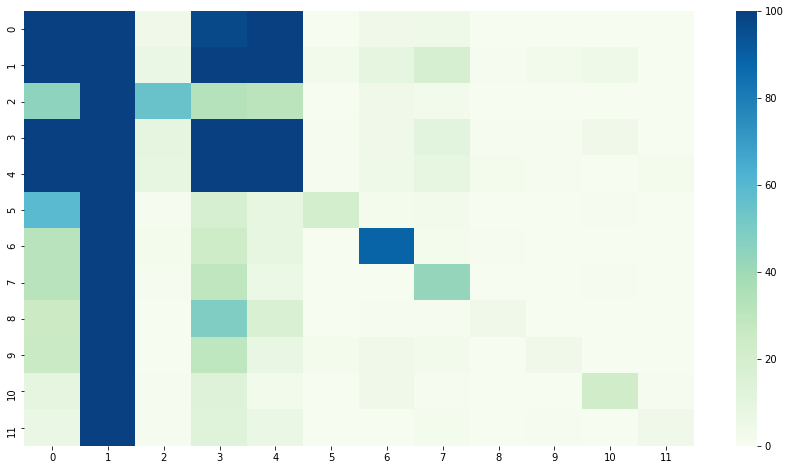

array([71,  2,  2, ...,  8,  2,  9])

In [12]:
mapper = DataFrameMapper([('normalized_text', 
                          TfidfVectorizer(sublinear_tf=True, 
                                          min_df=5, 
                                          stop_words='english', 
                                          norm='l2', 
                                          ngram_range=(1,3))),
                         ('episode_id', LabelEncoder()),
                         ('location_id', LabelEncoder()),
                         ('word_count', None)])

features = mapper.fit_transform(simpsons_df[['normalized_text', 'location_id', 'episode_id', 'word_count']])

x_train, x_test, y_train, y_test = train_test_split(features, 
                                                    simpsons_df['character_id'], 
                                                    random_state=42, 
                                                    test_size=0.2)
from sklearn.neural_network import MLPClassifier

svc = LogisticRegression(C=2)

svc.fit(x_train, y_train)

test_prediction = svc.predict(x_test)
print("The accuracy is:", accuracy_score(y_test, test_prediction))
print_cnf_matrix(y_test, test_prediction)
test_prediction

In [13]:
def fit_multiple_estimators(classifiers, X_list, y, sample_weights = None):

    # Convert the labels `y` using LabelEncoder, because the predict method is using index-based pointers
    # which will be converted back to original data later.
    le_ = LabelEncoder()
    le_.fit(y)
    transformed_y = le_.transform(y)

    # Fit all estimators with their respective feature arrays
    estimators_ = [clf.fit(X, y) if sample_weights is None else clf.fit(X, y, sample_weights) for clf, X in zip([clf for _, clf in classifiers], X_list)]

    return estimators_, le_

def predict_from_multiple_estimator(estimators, label_encoder, X_list, weights = None):

    # Predict 'soft' voting with probabilities

    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)
    pred = np.argmax(pred2, axis=1)

    # Convert integer predictions to original labels:
    return label_encoder.inverse_transform(pred)

In [14]:
mnb = MultinomialNB(alpha=0.33684210526315794)
mnb.fit(x_train_vec, y_train)
mnb.predict_proba(x_test_vec)



classifiers = [('mnb', MultinomialNB(alpha=0.33684210526315794)),('clf', DecisionTreeClassifier(random_state=42))]
x_list_train = [x_train_vec, x_train_others] 
x_list_test = [x_test_vec, x_test_other]

fitted_estimators, label_encoder = fit_multiple_estimators(classifiers, x_list_train, y_train)
y_pred = predict_from_multiple_estimator(fitted_estimators, label_encoder, x_list_test)

print(accuracy_score(y_test, y_pred))


0.3910544966957188


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The accuracy is: 0.4137534718896657


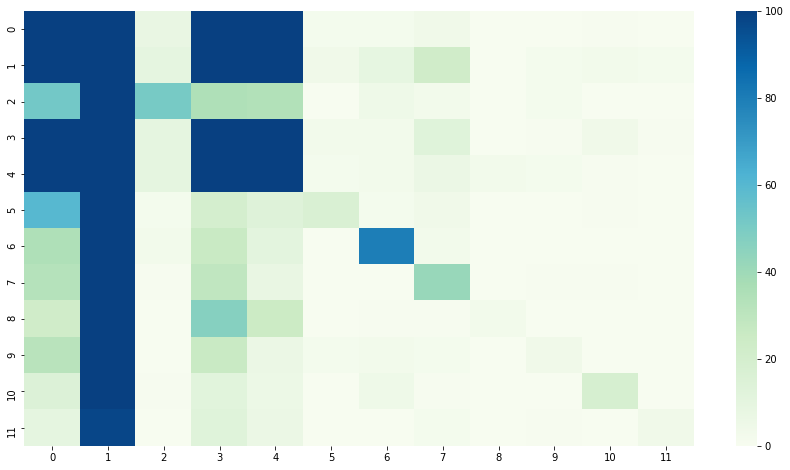

array([71,  2,  2, ...,  8,  2,  9])

In [15]:


svc = LogisticRegression(C=2)

svc.fit(x_train_vec, y_train)

test_prediction = svc.predict(x_test_vec)
print("The accuracy is:", accuracy_score(y_test, test_prediction))
print_cnf_matrix(y_test, test_prediction)
test_prediction